In [2]:
#WARNINGS
import warnings
warnings.filterwarnings('ignore')

# NUMPY 
import numpy as np

# STATS
import scipy.stats as stats
from scipy.stats import norm, skew

# MATPLOTLIB
import matplotlib as mlp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

# PANDAS
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None) 

# SEABORN
import seaborn as sns

# SCIKIT-LEARN: SELECTION DE VARIABLES

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# SCIKIT-LEARN: PRE-PROCESSING
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # Encodage des variables catégorielles ordinales
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder # Encodage des variables catégorielles nominales
from sklearn.preprocessing import StandardScaler # Normalisation des variables numériques
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer # Imputation
from sklearn.impute import KNNImputer 

# SCIKIT-LEARN: MODELES
from sklearn.linear_model import LogisticRegression

# SCIKIT-LEARN: VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split # Séparer en données train et test
from sklearn.model_selection import cross_val_score # Validation croisée pour comparison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation : visulaisr des scores lors du choix d'un hyper-paramètre
from sklearn.model_selection import GridSearchCV # Tester plusieurs hyper-paramètres
from sklearn.model_selection import learning_curve # Courbe d'apprentissage : visualisation des scores du train et du validation sets en fonction des quanitiés des données
 
## EVALUATION
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# SCHIKIT-LEARN: PIPELINE AND TRANSFORMATEURll
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import importlib
from importlib import reload

In [3]:
# import functions from data_preprocessing.py
import sys
import os

# Ajouter le chemin du dossier parent pour que Python puisse trouver le module 'data'
module_path = os.path.abspath(os.path.join('..'))
#print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    

from src import data_preprocessing
from data import extract_data
from src import evaluate
from src import hyperparameter_opt


In [4]:
data = extract_data.data
df = data.copy()

# Pretraitement

In [5]:
df = data_preprocessing.preprocess(df)
df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,>=50k
0,39.0,State-gov,77516.0,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,0
1,50.0,Self-emp-not-inc,83311.0,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,0
2,38.0,Private,215646.0,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,0
3,53.0,Private,234721.0,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,0
4,28.0,Private,338409.0,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,0


In [6]:
df_train, df_test = data_preprocessing.seperate_train_test(df, random_state=42)
cat_features = data_preprocessing.get_cat_features(df)
cont_features = data_preprocessing.get_cont_features(df)

In [7]:
cat_features

Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'sex', 'native-country', 'education-num'],
      dtype='object')

In [8]:
df_train,df_test = data_preprocessing.encode_cat_features(df_train, df_test, cat_features)
df_train,df_test = data_preprocessing.standardize(df_train, df_test, cont_features)

In [9]:
# reload the module to get the last changes
reload(data_preprocessing)
X_train, y_train = data_preprocessing.getX_y(df_train)
X_test, y_test = data_preprocessing.getX_y(df_test)

# Recherche hyper - parametres

### Regression Logistique Simple

In [10]:
logreg = LogisticRegression(penalty=None, tol=10e-6, random_state=7) # tol (hyperparametre) est la tolérance pour l'arrêt de l'optimisation , valeur minimale de la fonction de coût
logregRidge = LogisticRegression(C=0.1, penalty='l2', tol=10e-6, random_state=7) # plus C est bas plus la regularisation est forte.. C est l'inverse de lambda (parametre de régularisation)
logregLasso = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', tol=10e-6, random_state=7)
logregElasticNet = LogisticRegression(C=0.1, penalty='elasticnet', solver='saga', l1_ratio=0.7, tol=10e-6, random_state=7) # l1_ratio est le ratio de la pénalité L1 dans la pénalité L1 + L2


In [11]:
#def optimize_hyperparameters_GridSearch(model_name, X, y, categorical_features):
# reload the module to get the last changes
reload(hyperparameter_opt)
est = hyperparameter_opt.optimize_hyperparameters_GridSearch("logistic_regression", X_train, y_train, cat_features)


Best parameters for logistic_regression: {'classifier__C': 10, 'classifier__solver': 'saga'}
Best score for logistic_regression: 0.48663503798084073


In [12]:
param_grid = {'C': [0.001, 0.01, 0.1, 1., 10.], 'max_iter': [100, 200, 300, 400]}
grid = GridSearchCV(logregElasticNet, param_grid, verbose=False, n_jobs=1, return_train_score=True, scoring='f1')
# attention n_jobs=-1 va utiliser tous les CPUs
grid.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(C=0.1, l1_ratio=0.7,
                                          penalty='elasticnet', random_state=7,
                                          solver='saga', tol=1e-05),
             n_jobs=1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'max_iter': [100, 200, 300, 400]},
             return_train_score=True, scoring='f1', verbose=False)

In [13]:
grid.best_params_

{'C': 10.0, 'max_iter': 300}

In [14]:
grid.best_score_

0.5402889593494987

In [15]:
grid_logreg = grid.best_estimator_
grid_logreg

LogisticRegression(C=10.0, l1_ratio=0.7, max_iter=300, penalty='elasticnet',
                   random_state=7, solver='saga', tol=1e-05)

In [16]:
grid_logreg.score(X_train, y_train)

0.8243510920175957

In [17]:
grid_logreg.score(X_test, y_test)

0.8238501903488014

Régression logistique

Matrice de confusion:
[[7008  422]
 [1290  999]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7430
           1       0.70      0.44      0.54      2289

    accuracy                           0.82      9719
   macro avg       0.77      0.69      0.71      9719
weighted avg       0.81      0.82      0.81      9719
 

Exactitude: 82.385019 



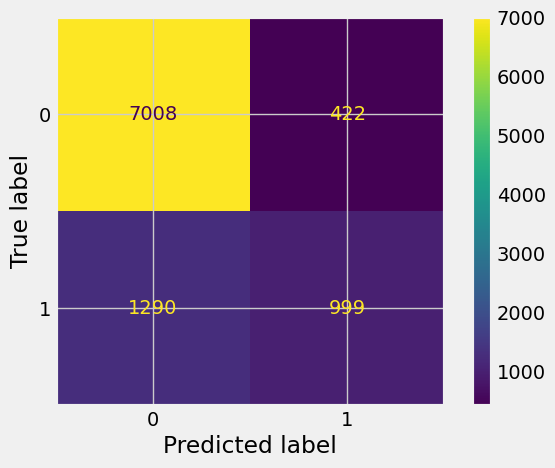

In [18]:
# performance de régression logistique avec GridSearchCV
y_pred = grid_logreg.predict(X_test)

print('='*20)
print('Régression logistique')
print('='*20, '\n')

print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred), '\n') # afficher à l'écran notre matrice de confusion
print("Rapport de classification:")
print(classification_report(y_test, y_pred), '\n')
print('Exactitude: %f' %(accuracy_score(y_test,y_pred)*100), '\n')
c_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
disp.plot()
plt.show()

In [ ]:
print(f"Best parameters for {model_name}: {grid.best_params_}")
print(f"Best score for {model_name}: {grid.best_score_}")


In [8]:
# Imputation et Normalisation
catgoricalPipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    )


preprocessor = make_column_transformer(
    (catgoricalPipeline, cat_features),
)
preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'sex', 'native-country', 'education-num'],
      dtype='object'))])